# Estimate Participant Stages

In this chapter, we will do some exercise to have a deeper understanding of the math equations in @sec-calc-ll.

## Challenge

Suppos we know $S, \theta, \phi$. How could we estimate participant stages?

In [170]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import json 
from collections import Counter

This is the data we have. And we want to know fill the missing column of `k_j`. 

In [171]:
output_dir = 'data'
df = pd.read_csv(f"{output_dir}/100|200_3.csv")
real_stages_dic = dict(zip(df.participant, df.k_j))
df.drop(['k_j', 'affected_or_not'], axis = 1, inplace=True)
df.head()

,participant,biomarker,measurement,S_n,diseased
0,0,HIP-FCI,-8.908479,1,True
1,1,HIP-FCI,-1.095464,1,False
2,2,HIP-FCI,0.470754,1,True
3,3,HIP-FCI,2.633455,1,True
4,4,HIP-FCI,4.070208,1,False


## Solution

One possible solution looks like this:

- For each diseased participant, we iterate through all possible disease stages and calculate the likelihood using @eq-known-kj.

- We normalize all the likelihoods, construct an array, and randomly sample one possible stage according to that array. 

- Run multiple times, for each diseased participant, the mode of the sampled stages will be their stage. 

In [172]:
#| code-fold: true

def compute_single_measurement_likelihood(
        theta_phi, 
        biomarker, 
        affected, 
        measurement):
    '''Computes the likelihood of the measurement value of a single biomarker

    We know the normal distribution defined by either theta or phi
    and we know the measurement. This will give us the probability
    of this given measurement value. 

    input:
    - theta_phi: the dictionary containing theta and phi values for each biomarker
    - biomarker: an integer between 0 and 9 
    - affected: boolean 
    - measurement: the observed value for a biomarker in a specific participant

    output: a scalar
    '''
    biomarker_dict = theta_phi[biomarker]
    mu = biomarker_dict['theta_mean'] if affected else biomarker_dict['phi_mean']
    std = biomarker_dict['theta_std'] if affected else biomarker_dict['phi_std']
    var = std**2
    if var <= int(0) or np.isnan(measurement) or np.isnan(mu):
        print(f"Invalid values: measurement: {measurement}, mu: {mu}, var: {var}")
        likelihood = np.exp(-(measurement - mu)**2 /
                            (2 * var)) / np.sqrt(2 * np.pi * var)
    else:
        likelihood = np.exp(-(measurement - mu)**2 /
                            (2 * var)) / np.sqrt(2 * np.pi * var)
    return likelihood

def fill_up_kj_and_affected(pdata, k_j):
    '''Fill up a single participant's data using k_j; basically add two columns: 
    k_j and affected
    Note that this function assumes that pdata already has the S_n column

    Input:
    - pdata: a dataframe of ten biomarker values for a specific participant 
    - k_j: a scalar
    '''
    data = pdata.copy()
    data['k_j'] = k_j
    data['affected'] = data.apply(lambda row: row.k_j >= row.S_n, axis=1)
    return data

def compute_likelihood(pdata, k_j, theta_phi):
    '''
    This function computes the likelihood of seeing this sequence of biomarker values 
    for a specific participant, assuming that this participant is at stage k_j
    '''
    data = fill_up_kj_and_affected(pdata, k_j)
    likelihood = 1
    for i, row in data.iterrows():
        biomarker = row['biomarker']
        measurement = row['measurement']
        affected = row['affected']
        likelihood *= compute_single_measurement_likelihood(
            theta_phi, biomarker, affected, measurement)
    return likelihood

We first look at the known $\theta, \phi$:

In [173]:
with open('files/real_theta_phi.json', 'r') as f:
    truth = json.load(f)
truth_df = pd.DataFrame.from_dict(truth, orient='index')
truth_df.reset_index(names = 'biomarker', inplace=True)
truth_df

,biomarker,theta_mean,theta_std,phi_mean,phi_std
0,MMSE,22.0,2.666667,28.0,0.666667
1,ADAS,-20.0,4.000000,-6.0,1.333333
2,AB,150.0,16.666667,250.0,50.000000
3,P-Tau,-50.0,33.333333,-25.0,16.666667
4,HIP-FCI,-5.0,6.666667,5.0,1.666667
5,HIP-GMI,0.3,0.333333,0.4,0.233333
6,AVLT-Sum,20.0,6.666667,40.0,15.000000
7,PCC-FCI,5.0,3.333333,12.0,4.000000
8,FUS-GMI,0.5,0.066667,0.6,0.066667
9,FUS-FCI,-20.0,6.000000,-10.0,3.333333


## Implementation

We then implement the algorithm mentioned above:

In [174]:
theta_phi_estimates = truth.copy()
disease_stages = df.S_n.unique()
diseased_participants = df[df.diseased==True]['participant'].unique()

In [175]:
def update_participant_stages_dic(
        data,
        p,
        disease_stages,
        theta_phi_estimates,
        # participant stage dic:
        psdic,
        sample_iterations = 20
):
    """
    Inputs:
        - data: pd.dataframe, e.g., 100|200_3.csv
        - p: int
        - disease_stages: a list of integers
        - theta_phi_estimates: a hashmap of dictionaries
        - psdic: a dictionary
        - sample_iteration: int. How many times we sample 
    Output:
        no outputs. Simply update psdic
    """
    pdata = data[data.participant == p]
    stage_likelihood_dict = {}
    for k_j in disease_stages:
        kj_likelihood = compute_likelihood(
            pdata, k_j, theta_phi_estimates)
        # update each stage likelihood for this participant
        stage_likelihood_dict[k_j] = kj_likelihood
    # Add a small epsilon to avoid division by zero
    likelihood_sum = sum(stage_likelihood_dict.values())
    epsilon = 1e-10
    if likelihood_sum == 0:
        # print("Invalid likelihood_sum: zero encountered.")
        likelihood_sum = epsilon  # Handle the case accordingly
    normalized_stage_likelihood = [
        l/likelihood_sum for l in stage_likelihood_dict.values()]
    sampled_stages = np.random.choice(
        disease_stages, 
        size = sample_iterations, 
        p=normalized_stage_likelihood, 
        replace=True
    )
    mode_result = Counter(sampled_stages).most_common(1)[0][0]
    psdic[p] = mode_result

In [176]:
participants = df.participant.unique()
psdic = {}
for p in participants:
    if p not in diseased_participants:
        psdic[p] = 0
    else:
        update_participant_stages_dic(
            df,
            p,
            disease_stages,
            theta_phi_estimates,
            # participant stage dic:
            psdic,
            sample_iterations = 10
    )

## Result

Then we compare our results with the actual participants' stages:

In [177]:
diff = np.array(list(psdic.values())) - np.array(list(real_stages_dic.values()))

In [178]:
#| code-fold: true

def scatter_plot_of_stage_differences(stage_differences):
    '''Scatter Plot of the Difference at each index
    Input:
    - stage_differences: estimated_stages - actual stages. Result should be a 1-dim np array
    '''
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(diff)), stage_differences, alpha=0.6)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title("Scatter Plot of Stage Difference for Each Participant")
    plt.xlabel("Participant")
    plt.ylabel("Difference (Estimated Stage - True Stage)")
    plt.grid(True)
    plt.show()

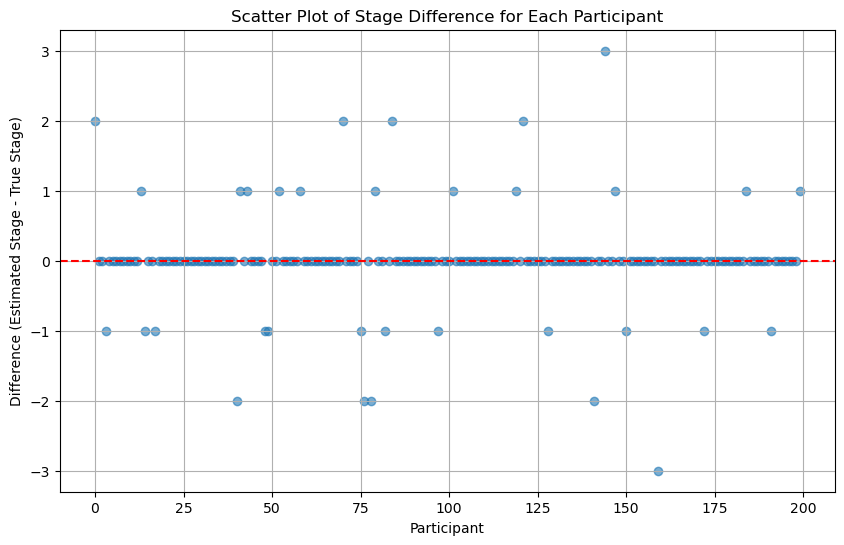

In [179]:
scatter_plot_of_stage_differences(diff)

## Discussion

From the above result, we can see how challenging it is to accurately estimate participant stages, **even if** we know exactly the $\theta$ and $\phi$.

:::{.callout-tip}

What if we know only $S$, but not $\theta$ nor $\phi$?

The first step for us is to estimate $\theta, \phi$ and then follow the above procedures. To do that, refer back to @sec-estimate-dist-params.

:::